# AOI Classification using (A) LeNet5, (B) AlexNet, (C) ResNet

## Outline:
* Step 01: Get a feel of data, draw it.
* Step 02: Define dataset class.
--------------------------------
* Step A1: Define LeNet5.
* Step A2: Setup dataloader for LeNet5.
* Step A3: Setup loss and hyper parameter for LeNet5.
* Step A4: Train LeNet5.
* Step A5: Evaluate the performance of LeNet5.
* Step A6: Test LeNet5.
--------------------------------
* Step B1: Define AlexNet.
* Step B2: Setup dataloader for AlexNet5.
* Step B3: Setup loss and hyper parameter for AlexNet5.
* Step B4: Train AlexNet5.
* Step B5: Evaluate the performance of AlexNet5.
* Step B6: Test AlexNet5.
--------------------------------
* Step C1: Define ResNet18.
* Step C2: Setup dataloader for ResNet18.
* Step C3: Setup loss and hyper parameter for ResNet18.
* Step C4: Train ResNet18.
* Step C5: Evaluate the performance of ResNet18.
* Step C6: Test ResNet18.

## Step 01: Get a feel of data, draw it.

In [1]:
import cv2 as cv # for reading image data
import matplotlib.pyplot as plt
import pandas as pd 
import os

%matplotlib inline

In [2]:
label_map_table = {
    0: "normal",
    1: "void",
    2: "Horizontal Defect",
    3: "Vertical Defect",
    4: "Edge Defect",
    5: "Partical"
}

In [23]:
df_train[100:150]

,ID,Label
100,train_00100.png,3
101,train_00101.png,0
102,train_00102.png,0
103,train_00103.png,0
104,train_00104.png,4
105,train_00105.png,0
106,train_00106.png,0
107,train_00107.png,5
108,train_00108.png,0
109,train_00109.png,0


[Label] => 2; [Label Actually Means] => Horizontal Defect


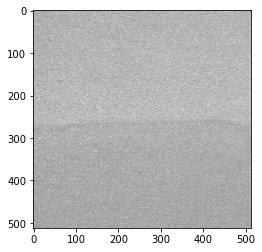

(512, 512, 3)


In [24]:
root_train = "../__HW5_DATA/train_images/"
root_test = "../__HW5_DATA/test_images/"
train_csv = "../__HW5_DATA/train.csv"
test_csv = "../__HW5_DATA/test.csv"
df_train = pd.read_csv(train_csv)

id = 137
png_img = cv.imread(root_train + df_train.ID[id])
label = df_train.Label[id]
print(f"[Label] => {df_train.Label[id]}; [Label Actually Means] => {label_map_table[label]}")
plt.imshow(png_img)
plt.show()

print(png_img.shape)

## Step 02: Define Dataset Class

In [4]:
from torch.utils.data.dataset import Dataset
from torchvision import transforms
import numpy as np
import pandas as pd
import cv2 as cv

# [Input Args]
# 1. target_csv <string>: It's the metadata file describe the name of image and its label.
# 2. root_path  <string>: It's the path to the image folder. Combination of this and name is the full path to the image.
# 3. height <int>: Use this for elastically resize image to desired shape.
# 4. width <int>: Use this for elastically resize image to desired shape.
class AOI_Dataset(Dataset):
    
    def __init__(self, target_csv, root_path, height, width, transform = None):
        
        # height, width
        self.height = height
        self.width = width
        
        # register self
        self.target_csv = target_csv
        self.root_path = root_path
        
        # 1. Read CSV file through root_path
        self.df = pd.read_csv(self.target_csv)
        
        # 2. Remember the length
        self.count = len(self.df)
        
        # 3. transform
        self.transforms = transform
    
    def __getitem__(self, index):
        # Read images
        img = cv.imread(self.root_path + self.df.ID[index])
        img_resize = cv.resize(img, (self.height, self.width))

        # To Tensor
        img_tensor = self.transforms(np.uint8(img_resize))
        
        # Get label
        label = self.df.Label[index]
        
        return (img_tensor, label)
    
    def __len__(self):
        return self.count

## Step A1: Define LeNet5.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Use GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d( 3,  6, 3, padding = 1)
        self.conv2 = nn.Conv2d( 6, 16, 3, padding = 1)
        self.conv3 = nn.Conv2d(16, 50, 3, padding = 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(50 * 64 * 64, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 6)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 50 * 64 * 64)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        #x = F.softmax(x)
        return x
    
lenet = LeNet()
print(lenet.to(device))

## Step A2: Setup dataloader for LeNet5.

In [ ]:
import torch
from torch.utils.data.sampler import SubsetRandomSampler
from torchsummary import summary

height = 512
width = 512

transform_train = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((height + 200, width + 200)),
    transforms.CenterCrop((height + 100, width + 100)),
    transforms.RandomCrop((height, width)),
    transforms.RandomHorizontalFlip(p = 0.5),
    transforms.RandomVerticalFlip(p = 0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

if torch.cuda.is_available(): summary(lenet, (3, height, width))
Train_Dataset = AOI_Dataset(target_csv = train_csv, root_path = root_train, height = height, width = width, transform = transform_train)

batch_size = 8
validation_split = .2
shuffle_dataset = True
random_seed= 43

# Creating data indices for training and validation splits:
dataset_size = len(Train_Dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

Train_DataLoader = torch.utils.data.DataLoader(Train_Dataset, batch_size=batch_size, sampler=train_sampler)
Val_DataLoader = torch.utils.data.DataLoader(Train_Dataset, batch_size=batch_size, sampler=valid_sampler)

## Step A3: Setup loss and hyper parameter for LeNet5.

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(lenet.parameters(), lr=1e-4)
epoch = 30

## Step A4: Train LeNet5.

In [ ]:
from tqdm import tqdm
import time

tic = time.time()
train_acc_list = []
val_acc_list = []
loss_list = []
print_probe_num = 100
for epoch in range(epoch):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(Train_DataLoader, 0):
        inputs, labels = data[0].to(device), data[1].to(device) # GPU        
        optimizer.zero_grad()

        outputs = lenet(inputs.float())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % print_probe_num == (print_probe_num - 1):
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / print_probe_num))
            loss_list.append(running_loss / print_probe_num)
            running_loss = 0.0
            
    correct = 0
    total = 0
    # Train
    with torch.no_grad(): # since we're not training, we don't need to calculate the gradients for our outputs
        for datum in tqdm(Train_DataLoader):

            imgs, labs = datum[0].to(device), datum[1].to(device)
            # calculate outputs by running images through the network 
            outputs = lenet(imgs.float())
            # the class with the highest energy is what we choose as prediction
            _, preds = torch.max(outputs.data, 1)
            
            total += labs.size(0)
            correct += (preds == labs).sum().item()
        train_acc_list.append(float(correct)/float(total))
        print('Accuracy of the network on the train images: %d %%' % (100 * correct / total))
  

    correct = 0
    total = 0
    # Train
    with torch.no_grad(): # since we're not training, we don't need to calculate the gradients for our outputs
        for datum in tqdm(Val_DataLoader):

            imgs, labs = datum[0].to(device), datum[1].to(device)
            # calculate outputs by running images through the network 
            outputs = lenet(imgs.float())
            # the class with the highest energy is what we choose as prediction
            _, preds = torch.max(outputs.data, 1)
            
            total += labs.size(0)
            correct += (preds == labs).sum().item()
        val_acc_list.append(float(correct)/float(total))
        print('Accuracy of the network on the val images: %d %%' % (100 * correct / total))
toc = time.time()
print(f"Spend {round(toc - tic, 2)} (sec)")
print('Finished Training')

## Step A5: Evaluate the performance of LeNet5.

In [ ]:
import matplotlib.pyplot as plt

## Accuracy

plt.figure(figsize = (20, 10))
plt.title("LeNet5: Accuracy Curve", fontsize = 24)
plt.xlabel("Epochs"    , fontsize = 20)
plt.ylabel("Accuracy %", fontsize = 20)
plt.plot(train_acc_list, label = "train acc.")
plt.plot(val_acc_list  , label = "val acc.")
plt.legend(loc = 2, fontsize = 20)
plt.show()

## Loss

plt.figure(figsize=(20, 10))
plt.title("LeNet5: Loss Curve", fontsize = 24)
plt.plot(loss_list)
plt.xlabel("Probes", fontsize = 20)
plt.ylabel("Loss", fontsize = 20)
plt.show()

## Step A6: Test LeNet5.

In [ ]:
transform_test = transforms.Compose([
    transforms.ToPILImage(),
    #transforms.Resize((height + 200, width + 200)),
    #transforms.CenterCrop((height + 100, width + 100)),
    #transforms.RandomCrop((height, width)),
    #transforms.RandomHorizontalFlip(p = 0.5),
    #transforms.RandomVerticalFlip(p = 0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

Test_Dataset = AOI_Dataset(target_csv = test_csv, root_path = root_test, height = height, width = width, transform = transform_test)
Test_DataLoader = torch.utils.data.DataLoader(dataset = Test_Dataset, batch_size = 1, shuffle = False)
Name_of_csv_file = "test01_0519.csv"

df_test = pd.read_csv(test_csv)
df_test_np = df_test.to_numpy()

count = -1
with torch.no_grad(): # since we're not training, we don't need to calculate the gradients for our outputs
    for datum in tqdm(Test_DataLoader):
        count = count + 1
        imgs = datum[0].to(device)
        # calculate outputs by running images through the network 
        outputs = lenet(imgs.float())
        # the class with the highest energy is what we choose as prediction
        _, preds = torch.max(outputs.data, 1)
        df_test_np[count][1] = float(preds)
        
df = pd.DataFrame(df_test_np, columns = ['ID','Label'])
df.to_csv(Name_of_csv_file, index=False)

## Step B1: Define AlexNet.
* Get the AlexNet from the link below.
* github ref link: https://github.com/pytorch/vision/blob/master/torchvision/models/alexnet.py

In [ ]:
import torch
import torch.nn as nn

class AlexNet(nn.Module):

    def __init__(self, num_classes: int = 6) -> None:
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Use GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

alexnet = AlexNet()
print(alexnet.to(device))

## Step B2: Setup dataloader for AlexNet5.

In [ ]:
import torch
from torch.utils.data.sampler import SubsetRandomSampler
from torchsummary import summary

height = 512
width = 512

transform_train = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((height + 200, width + 200)),
    transforms.CenterCrop((height + 100, width + 100)),
    transforms.RandomCrop((height, width)),
    transforms.RandomHorizontalFlip(p = 0.5),
    transforms.RandomVerticalFlip(p = 0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

if torch.cuda.is_available(): summary(alexnet, (3, height, width))
Train_Dataset = AOI_Dataset(target_csv = train_csv, root_path = root_train, width=width, height=height, transform = transform_train)

batch_size = 8
validation_split = .2
shuffle_dataset = True
random_seed= 43

# Creating data indices for training and validation splits:
dataset_size = len(Train_Dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

Train_DataLoader = torch.utils.data.DataLoader(Train_Dataset, batch_size=batch_size, sampler=train_sampler)
Val_DataLoader = torch.utils.data.DataLoader(Train_Dataset, batch_size=batch_size, sampler=valid_sampler)

## Step B3: Setup loss and hyper parameter for AlexNet.

In [ ]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(alexnet.parameters(), lr=1e-5)
epoch = 30

## Step B4: Train AlexNet.

In [ ]:
from tqdm import tqdm
import time

tic = time.time()
train_acc_list = []
val_acc_list = []
loss_list = []
print_probe_num = 100
for epoch in range(epoch):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(Train_DataLoader, 0):
        inputs, labels = data[0].to(device), data[1].to(device) # GPU        
        optimizer.zero_grad()

        outputs = alexnet(inputs.float())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        _, preds = torch.max(outputs.data, 1)

        running_loss += loss.item()
        if i % print_probe_num == (print_probe_num - 1):
            print('[%d, %5d] loss: %.6f' % (epoch + 1, i + 1, running_loss / print_probe_num))
            loss_list.append(running_loss / print_probe_num)
            running_loss = 0.0
            
    correct = 0
    total = 0
    # Train
    with torch.no_grad(): # since we're not training, we don't need to calculate the gradients for our outputs
        for datum in tqdm(Train_DataLoader):

            imgs, labs = datum[0].to(device), datum[1].to(device)
            # calculate outputs by running images through the network 
            outputs = alexnet(imgs.float())
            # the class with the highest energy is what we choose as prediction
            _, preds = torch.max(outputs.data, 1)
            
            total += labs.size(0)
            correct += (preds == labs).sum().item()
        train_acc_list.append(float(correct)/float(total))
        print('Accuracy of the network on the train images: %d %%' % (100 * correct / total))
        
    correct = 0
    total = 0
    # Val
    with torch.no_grad(): # since we're not training, we don't need to calculate the gradients for our outputs
        for datum in tqdm(Val_DataLoader):

            imgs, labs = datum[0].to(device), datum[1].to(device)
            # calculate outputs by running images through the network 
            outputs = alexnet(imgs.float())
            # the class with the highest energy is what we choose as prediction
            _, preds = torch.max(outputs.data, 1)
            
            total += labs.size(0)
            correct += (preds == labs).sum().item()
        val_acc_list.append(float(correct)/float(total))
        print('Accuracy of the network on the val images: %d %%' % (100 * correct / total))
        
toc = time.time()
print(f"Spend {round(toc - tic, 2)} (sec)")
print('Finished Training')

## Step B5: Evaluate the performance of AlexNet.

In [ ]:
import matplotlib.pyplot as plt

## Accuracy

plt.figure(figsize = (20, 10))
plt.title("AlexNet: Accuracy Curve", fontsize = 24)
plt.xlabel("Epochs"    , fontsize = 20)
plt.ylabel("Accuracy %", fontsize = 20)
plt.plot(train_acc_list, label = "train acc.")
plt.plot(val_acc_list  , label = "val acc.")
plt.legend(loc = 2, fontsize = 20)
plt.show()

## Loss

plt.figure(figsize=(20, 10))
plt.title("AlexNet: Loss Curve", fontsize = 24)
plt.plot(loss_list)
plt.xlabel("Probes", fontsize = 20)
plt.ylabel("Loss", fontsize = 20)
plt.show()

## Step B6: Test AlexNet5.

In [ ]:
transform_test = transforms.Compose([
    transforms.ToPILImage(),
    #transforms.Resize((height + 200, width + 200)),
    #transforms.CenterCrop((height + 100, width + 100)),
    #transforms.RandomCrop((height, width)),
    #transforms.RandomHorizontalFlip(p = 0.5),
    #transforms.RandomVerticalFlip(p = 0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

Test_Dataset = AOI_Dataset(target_csv = test_csv, root_path = root_test, height = height , width = width, transform = transform_test)
Test_DataLoader = torch.utils.data.DataLoader(dataset = Test_Dataset, batch_size = 1, shuffle = False)
Name_of_csv_file = "alexnet_test01.csv"

df_test = pd.read_csv(test_csv)
df_test_np = df_test.to_numpy()

count = -1
with torch.no_grad(): # since we're not training, we don't need to calculate the gradients for our outputs
    for datum in tqdm(Test_DataLoader):
        count = count + 1
        imgs = datum[0].to(device)
        # calculate outputs by running images through the network 
        outputs = alexnet(imgs.float())
        # the class with the highest energy is what we choose as prediction
        _, preds = torch.max(outputs.data, 1)
        df_test_np[count][1] = float(preds)
        
df = pd.DataFrame(df_test_np, columns = ['ID','Label'])
df.to_csv(Name_of_csv_file, index = False)

## C1: Define ResNet18.
* Get the ResNet18 from the link below.
* medium ref link: https://towardsdatascience.com/residual-network-implementing-resnet-a7da63c7b278

In [5]:
from functools import partial
import torch
import torch.nn as nn

class Conv2dAuto(nn.Conv2d):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.padding =  (self.kernel_size[0] // 2, self.kernel_size[1] // 2) # dynamic add padding based on the kernel_size
        
conv3x3 = partial(Conv2dAuto, kernel_size=3, bias=False)

def activation_func(activation):
    return  nn.ModuleDict([
        ['relu', nn.ReLU(inplace=True)],
        ['leaky_relu', nn.LeakyReLU(negative_slope=0.01, inplace=True)],
        ['selu', nn.SELU(inplace=True)],
        ['none', nn.Identity()]
    ])[activation]

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, activation='relu'):
        super().__init__()
        self.in_channels, self.out_channels, self.activation = in_channels, out_channels, activation
        self.blocks = nn.Identity()
        self.activate = activation_func(activation)
        self.shortcut = nn.Identity()   
    
    def forward(self, x):
        residual = x
        if self.should_apply_shortcut: residual = self.shortcut(x)
        x = self.blocks(x)
        x += residual
        x = self.activate(x)
        return x
    
    @property
    def should_apply_shortcut(self):
        return self.in_channels != self.out_channels
    
class ResNetResidualBlock(ResidualBlock):
    def __init__(self, in_channels, out_channels, expansion=1, downsampling=1, conv=conv3x3, *args, **kwargs):
        super().__init__(in_channels, out_channels, *args, **kwargs)
        self.expansion, self.downsampling, self.conv = expansion, downsampling, conv
        self.shortcut = nn.Sequential(
            nn.Conv2d(self.in_channels, self.expanded_channels, kernel_size=1,
                      stride=self.downsampling, bias=False),
            nn.BatchNorm2d(self.expanded_channels)) if self.should_apply_shortcut else None
        
        
    @property
    def expanded_channels(self):
        return self.out_channels * self.expansion
    
    @property
    def should_apply_shortcut(self):
        return self.in_channels != self.expanded_channels
    
def conv_bn(in_channels, out_channels, conv, *args, **kwargs):
    return nn.Sequential(conv(in_channels, out_channels, *args, **kwargs), nn.BatchNorm2d(out_channels))

class ResNetBasicBlock(ResNetResidualBlock):
    """
    Basic ResNet block composed by two layers of 3x3conv/batchnorm/activation
    """
    expansion = 1
    def __init__(self, in_channels, out_channels, *args, **kwargs):
        super().__init__(in_channels, out_channels, *args, **kwargs)
        self.blocks = nn.Sequential(
            conv_bn(self.in_channels, self.out_channels, conv=self.conv, bias=False, stride=self.downsampling),
            activation_func(self.activation),
            conv_bn(self.out_channels, self.expanded_channels, conv=self.conv, bias=False),
        )

class ResNetBottleNeckBlock(ResNetResidualBlock):
    expansion = 4
    def __init__(self, in_channels, out_channels, *args, **kwargs):
        super().__init__(in_channels, out_channels, expansion=4, *args, **kwargs)
        self.blocks = nn.Sequential(
           conv_bn(self.in_channels, self.out_channels, self.conv, kernel_size=1),
             activation_func(self.activation),
             conv_bn(self.out_channels, self.out_channels, self.conv, kernel_size=3, stride=self.downsampling),
             activation_func(self.activation),
             conv_bn(self.out_channels, self.expanded_channels, self.conv, kernel_size=1),
        )
        
class ResNetLayer(nn.Module):
    """
    A ResNet layer composed by `n` blocks stacked one after the other
    """
    def __init__(self, in_channels, out_channels, block=ResNetBasicBlock, n=1, *args, **kwargs):
        super().__init__()
        # 'We perform downsampling directly by convolutional layers that have a stride of 2.'
        downsampling = 2 if in_channels != out_channels else 1
        self.blocks = nn.Sequential(
            block(in_channels , out_channels, *args, **kwargs, downsampling=downsampling),
            *[block(out_channels * block.expansion, 
                    out_channels, downsampling=1, *args, **kwargs) for _ in range(n - 1)]
        )

    def forward(self, x):
        x = self.blocks(x)
        return x
    
class ResNetEncoder(nn.Module):
    """
    ResNet encoder composed by layers with increasing features.
    """
    def __init__(self, in_channels=3, blocks_sizes=[64, 128, 256, 512], deepths=[2,2,2,2], 
                 activation='relu', block=ResNetBasicBlock, *args, **kwargs):
        super().__init__()
        self.blocks_sizes = blocks_sizes
        
        self.gate = nn.Sequential(
            nn.Conv2d(in_channels, self.blocks_sizes[0], kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(self.blocks_sizes[0]),
            activation_func(activation),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        
        self.in_out_block_sizes = list(zip(blocks_sizes, blocks_sizes[1:]))
        self.blocks = nn.ModuleList([ 
            ResNetLayer(blocks_sizes[0], blocks_sizes[0], n=deepths[0], activation=activation, 
                        block=block,*args, **kwargs),
            *[ResNetLayer(in_channels * block.expansion, 
                          out_channels, n=n, activation=activation, 
                          block=block, *args, **kwargs) 
              for (in_channels, out_channels), n in zip(self.in_out_block_sizes, deepths[1:])]       
        ])
        
        
    def forward(self, x):
        x = self.gate(x)
        for block in self.blocks:
            x = block(x)
        return x
    
class ResnetDecoder(nn.Module):
    """
    This class represents the tail of ResNet. It performs a global pooling and maps the output to the
    correct class by using a fully connected layer.
    """
    def __init__(self, in_features, n_classes):
        super().__init__()
        self.avg = nn.AdaptiveAvgPool2d((1, 1))
        self.decoder = nn.Linear(in_features, n_classes)

    def forward(self, x):
        x = self.avg(x)
        x = x.view(x.size(0), -1)
        x = self.decoder(x)
        return x
    
class ResNet(nn.Module):
    
    def __init__(self, in_channels, n_classes, *args, **kwargs):
        super().__init__()
        self.encoder = ResNetEncoder(in_channels, *args, **kwargs)
        self.decoder = ResnetDecoder(self.encoder.blocks[-1].blocks[-1].expanded_channels, n_classes)
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
def resnet18(in_channels, n_classes, block=ResNetBasicBlock, *args, **kwargs):
    return ResNet(in_channels, n_classes, block=block, deepths=[2, 2, 2, 2], *args, **kwargs)


# Use GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

resnet = resnet18(3, 6)
print(resnet.to(device))

cuda:0
ResNet(
  (encoder): ResNetEncoder(
    (gate): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (blocks): ModuleList(
      (0): ResNetLayer(
        (blocks): Sequential(
          (0): ResNetBasicBlock(
            (blocks): Sequential(
              (0): Sequential(
                (0): Conv2dAuto(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )
              (1): ReLU(inplace=True)
              (2): Sequential(
                (0): Conv2dAuto(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, 

## Step C2: Setup dataloader for ResNet18.

In [6]:
import torch
from torch.utils.data.sampler import SubsetRandomSampler
from torchsummary import summary

height = 512
width = 512

trainsform_train = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((height + 200, width + 200)),
    transforms.CenterCrop((height + 100, width + 100)),
    transforms.RandomCrop((height, width)),
    transforms.RandomHorizontalFlip(p = 0.5),
    transforms.RandomVerticalFlip(p = 0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

if torch.cuda.is_available(): summary(resnet, (3, height, width))
Train_Dataset = AOI_Dataset(target_csv = train_csv, root_path = root_train, width = width, height = height, transform = trainsform_train)

batch_size = 8
validation_split = .2
shuffle_dataset = True
random_seed= 43

# Creating data indices for training and validation splits:
dataset_size = len(Train_Dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

Train_DataLoader = torch.utils.data.DataLoader(Train_Dataset, batch_size = batch_size, sampler = train_sampler)
Val_DataLoader = torch.utils.data.DataLoader(Train_Dataset, batch_size = batch_size, sampler = valid_sampler)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           9,408
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
         MaxPool2d-4         [-1, 64, 128, 128]               0
        Conv2dAuto-5         [-1, 64, 128, 128]          36,864
       BatchNorm2d-6         [-1, 64, 128, 128]             128
              ReLU-7         [-1, 64, 128, 128]               0
        Conv2dAuto-8         [-1, 64, 128, 128]          36,864
       BatchNorm2d-9         [-1, 64, 128, 128]             128
             ReLU-10         [-1, 64, 128, 128]               0
 ResNetBasicBlock-11         [-1, 64, 128, 128]               0
       Conv2dAuto-12         [-1, 64, 128, 128]          36,864
      BatchNorm2d-13         [-1, 64, 128, 128]             128
             ReLU-14         [-1, 64, 1

## Step C3: Setup loss and hyper parameter for ResNet18.

In [7]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(resnet.parameters(), lr=1e-4)
epoch = 10

## Step C4: Train ResNet18.

In [8]:
from tqdm import tqdm
import time

tic = time.time()
train_acc_list = []
val_acc_list = []
loss_list = []
print_probe_num = 100

for epoch in range(epoch):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(Train_DataLoader, 0):
        inputs, labels = data[0].to(device), data[1].to(device) # GPU        
        optimizer.zero_grad()

        outputs = resnet(inputs.float())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        _, preds = torch.max(outputs.data, 1)

        running_loss += loss.item()
        if i % print_probe_num == (print_probe_num - 1):
            print('[%d, %5d] loss: %.6f' % (epoch + 1, i + 1, running_loss / print_probe_num))
            loss_list.append(running_loss / print_probe_num)
            running_loss = 0.0
            
    correct = 0
    total = 0
    # Train
    with torch.no_grad(): # since we're not training, we don't need to calculate the gradients for our outputs
        for datum in tqdm(Train_DataLoader):

            imgs, labs = datum[0].to(device), datum[1].to(device)
            # calculate outputs by running images through the network 
            outputs = resnet(imgs.float())
            # the class with the highest energy is what we choose as prediction
            _, preds = torch.max(outputs.data, 1)

            total += labs.size(0)
            correct += (preds == labs).sum().item()
        train_acc_list.append(float(correct)/float(total))
        print('Accuracy of the network on the train images: %d %%' % (100 * correct / total))
        
    correct = 0
    total = 0
    # Val
    with torch.no_grad(): # since we're not training, we don't need to calculate the gradients for our outputs
        for datum in tqdm(Val_DataLoader):

            imgs, labs = datum[0].to(device), datum[1].to(device)
            # calculate outputs by running images through the network 
            outputs = resnet(imgs.float())
            # the class with the highest energy is what we choose as prediction
            _, preds = torch.max(outputs.data, 1)
            
            total += labs.size(0)
            correct += (preds == labs).sum().item()
        val_acc_list.append(float(correct)/float(total))
        print('Accuracy of the network on the val images: %d %%' % (100 * correct / total))
        
toc = time.time()
print(f"Spend {round(toc - tic, 2)} (sec)")
print('Finished Training')

[1,   100] loss: 1.324087
[1,   200] loss: 0.969451


  0%|                                                                                           | 0/64 [00:00<?, ?it/s]

Accuracy of the network on the train images: 69 %


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:36<00:00,  1.75it/s]


Accuracy of the network on the val images: 68 %
[2,   100] loss: 0.821602
[2,   200] loss: 0.758317


  0%|                                                                                           | 0/64 [00:00<?, ?it/s]

Accuracy of the network on the train images: 75 %


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:34<00:00,  1.83it/s]


Accuracy of the network on the val images: 75 %
[3,   100] loss: 0.687008
[3,   200] loss: 0.673175


  0%|                                                                                           | 0/64 [00:00<?, ?it/s]

Accuracy of the network on the train images: 76 %


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:35<00:00,  1.83it/s]


Accuracy of the network on the val images: 76 %
[4,   100] loss: 0.545567
[4,   200] loss: 0.565710


  0%|                                                                                           | 0/64 [00:00<?, ?it/s]

Accuracy of the network on the train images: 82 %


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:35<00:00,  1.80it/s]


Accuracy of the network on the val images: 81 %
[5,   100] loss: 0.587135
[5,   200] loss: 0.520245


  0%|                                                                                           | 0/64 [00:00<?, ?it/s]

Accuracy of the network on the train images: 83 %


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:36<00:00,  1.77it/s]


Accuracy of the network on the val images: 84 %
[6,   100] loss: 0.477242
[6,   200] loss: 0.438302


  0%|                                                                                           | 0/64 [00:00<?, ?it/s]

Accuracy of the network on the train images: 85 %


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:35<00:00,  1.79it/s]


Accuracy of the network on the val images: 82 %
[7,   100] loss: 0.453884
[7,   200] loss: 0.406456


  0%|                                                                                           | 0/64 [00:00<?, ?it/s]

Accuracy of the network on the train images: 86 %


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:35<00:00,  1.79it/s]


Accuracy of the network on the val images: 86 %
[8,   100] loss: 0.337944
[8,   200] loss: 0.411060


  0%|                                                                                           | 0/64 [00:00<?, ?it/s]

Accuracy of the network on the train images: 85 %


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:36<00:00,  1.78it/s]


Accuracy of the network on the val images: 86 %
[9,   100] loss: 0.313406
[9,   200] loss: 0.386225


  0%|                                                                                           | 0/64 [00:00<?, ?it/s]

Accuracy of the network on the train images: 89 %


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:36<00:00,  1.77it/s]


Accuracy of the network on the val images: 87 %
[10,   100] loss: 0.307128
[10,   200] loss: 0.340736


  0%|                                                                                           | 0/64 [00:00<?, ?it/s]

Accuracy of the network on the train images: 90 %


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:36<00:00,  1.76it/s]

Accuracy of the network on the val images: 88 %
Spend 4910.56 (sec)
Finished Training


## Step C5: Evaluate the performance of ResNet18.

In [ ]:
import matplotlib.pyplot as plt

## Accuracy

plt.figure(figsize = (20, 10))
plt.title("ResNet18: Accuracy Curve", fontsize = 24)
plt.xlabel("Epochs"    , fontsize = 20)
plt.ylabel("Accuracy %", fontsize = 20)
plt.plot(train_acc_list, label = "train acc.")
plt.plot(val_acc_list  , label = "val acc.")
plt.legend(loc = 2, fontsize = 20)
plt.show()

## Loss

plt.figure(figsize=(20, 10))
plt.title("ResNet18: Loss Curve", fontsize = 24)
plt.plot(loss_list)
plt.xlabel("Probes", fontsize = 20)
plt.ylabel("Loss", fontsize = 20)
plt.show()

## Step C6: Test ResNet18.

In [ ]:
transform_test = transforms.Compose([
    transforms.ToPILImage(),
    #transforms.Resize((height + 200, width + 200)),
    #transforms.CenterCrop((height + 100, width + 100)),
    #transforms.RandomCrop((height, width)),
    #transforms.RandomHorizontalFlip(p = 0.5),
    #transforms.RandomVerticalFlip(p = 0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

Test_Dataset = AOI_Dataset(target_csv = test_csv, root_path = root_test, width = width, height = height, transform = transform_test)
Test_DataLoader = torch.utils.data.DataLoader(dataset = Test_Dataset, batch_size = 1, shuffle = False)
Name_of_csv_file = "resnet_test02.csv"

df_test = pd.read_csv(test_csv)
df_test_np = df_test.to_numpy()

count = -1
with torch.no_grad(): # since we're not training, we don't need to calculate the gradients for our outputs
    for datum in tqdm(Test_DataLoader):
        count = count + 1
        imgs = datum[0].to(device)
        # calculate outputs by running images through the network 
        outputs = resnet(imgs.float())
        # the class with the highest energy is what we choose as prediction
        _, preds = torch.max(outputs.data, 1)
        print(preds)
        df_test_np[count][1] = float(preds)
        
df = pd.DataFrame(df_test_np, columns = ['ID','Label'])
df.to_csv(Name_of_csv_file, index=False)